# corresponding to the getting_started page in /usage

0. Instantiate the module. Make sure you have all the prerequisite packages installed.

In [1]:
import numpy as np
import dense_basis as db

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Initialized stellar population with FSPS.


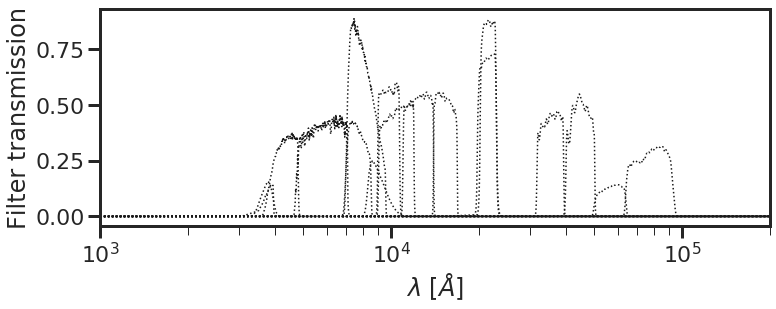

In [2]:
filter_list = 'dense_basis/filters/filter_list_goodss.dat'
db.plot_filterset(filter_list)

# Prerequisites to fitting: 

### 1. Instantiate a Priors() object

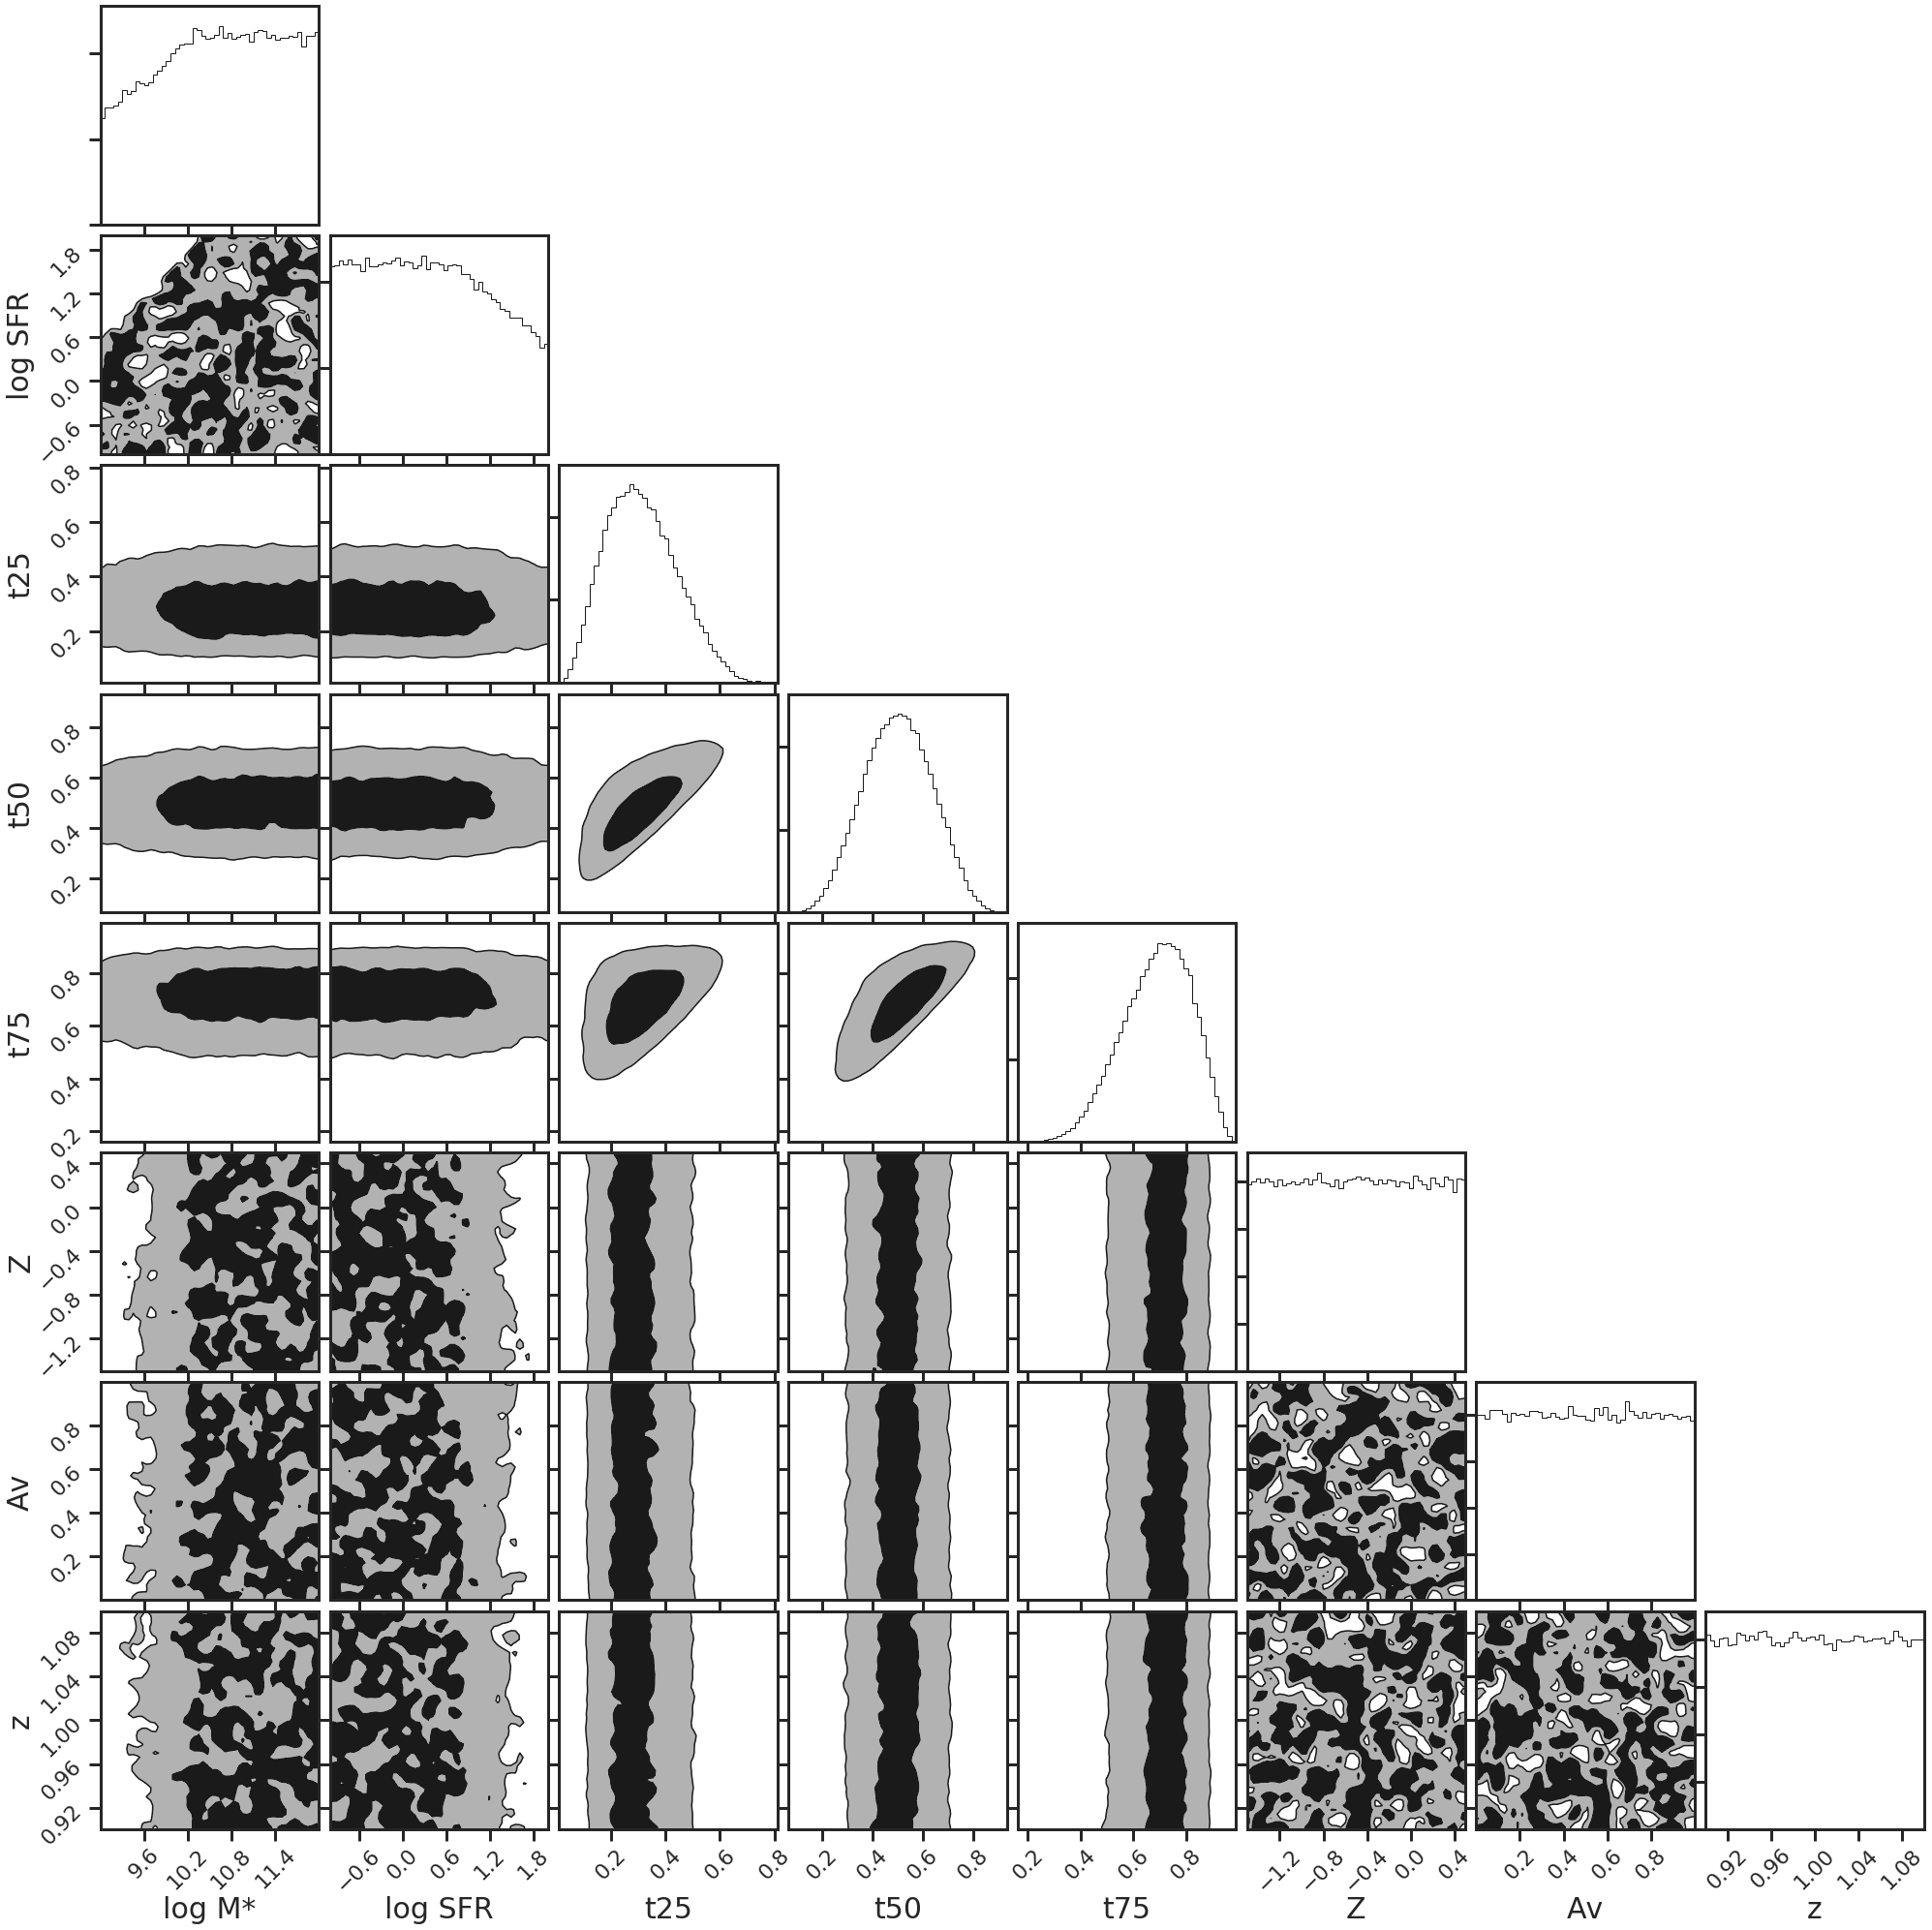

In [144]:
priors = db.Priors()
priors.tx_alpha = 3.0
priors.squeeze_tx = True
priors.plot_prior_distributions()

### 2. Generate an atlas of parameters drawn from the prior and their corresponding SEDs.

In [145]:
fname = 'test_atlas'
N_pregrid = 10000
priors.Nparam = 3
db.generate_atlas(N_pregrid = N_pregrid, 
                  priors = priors, 
                  fname = fname, store=True, 
                  filter_list = filter_list)

100%|██████████| 10000/10000 [08:55<00:00, 18.69it/s]


In [ ]:
fname = 'test_atlas'
N_pregrid = 100000
priors.Nparam = 3
db.generate_atlas(N_pregrid = N_pregrid, 
                  priors = priors, 
                  fname = fname, store=True, 
                  filter_list = filter_list)

  6%|▌         | 5972/100000 [05:21<1:24:11, 18.62it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 43%|████▎     | 42802/100000 [38:23<52:49, 18.05it/s]  

In [ ]:
fname = 'test_atlas'
N_pregrid = 300000
priors.Nparam = 3
db.generate_atlas(N_pregrid = N_pregrid, 
                  priors = priors, 
                  fname = fname, store=True, 
                  filter_list = filter_list)

### 3. Generate a mock SED to be fit.

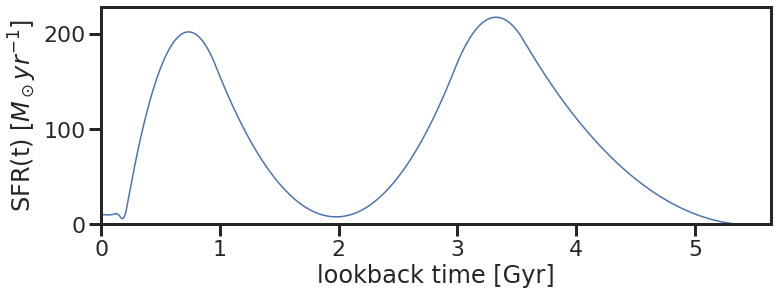

In [136]:
# sample from the prior space to get parameters 
rand_sfh_tuple, rand_Z, rand_Av, rand_z = priors.sample_all_params_safesSFR(random_seed = 6)

# generate an SFH corresponding to the SFH-tuple and see how it looks: 
rand_sfh, rand_time = db.tuple_to_sfh(rand_sfh_tuple, zval = rand_z) 
fig = db.plot_sfh(rand_time, rand_sfh, lookback=True) 
sfh_truths = [rand_time, rand_sfh]

# generate a corresponding spectrum and multiply by filter curves to get the SED: 
_, sfr_true, mstar_true = db.make_spec(rand_sfh_tuple, rand_Z, rand_Av, rand_z, return_ms = True)
rand_spec, rand_lam = db.make_spec(rand_sfh_tuple, rand_Z, rand_Av, rand_z, return_lam = True)
obs_sed = db.calc_fnu_sed(rand_spec, rand_z, rand_lam, fkit_name = filter_list) 
obs_err = obs_sed * 0.1 # S/N of 10
sed_truths = (mstar_true, sfr_true, rand_sfh_tuple[3:], rand_Z, rand_Av, rand_z)
sed_truths = np.hstack(sed_truths)

# SED fitting with the dense_basis package:

### 4. Load the previously generated atlas:

In [137]:
# load the atlas 
pg_sfhs, pg_Z, pg_Av, pg_z, pg_seds, norm_method = db.load_atlas(fname, N_pregrid, priors.Nparam) 
pg_theta = [pg_sfhs, pg_Z, pg_Av, pg_z, pg_seds]

# pass the atlas and the observed SED into the fitter, 
# fit params returns the median and 1-sigma values for the parameters being fit 
fit_params = db.fit_sed_pregrid(obs_sed, obs_err, pg_theta, norm_method=norm_method)

### 5. Fit the SED and visualize the parameter posteriors:

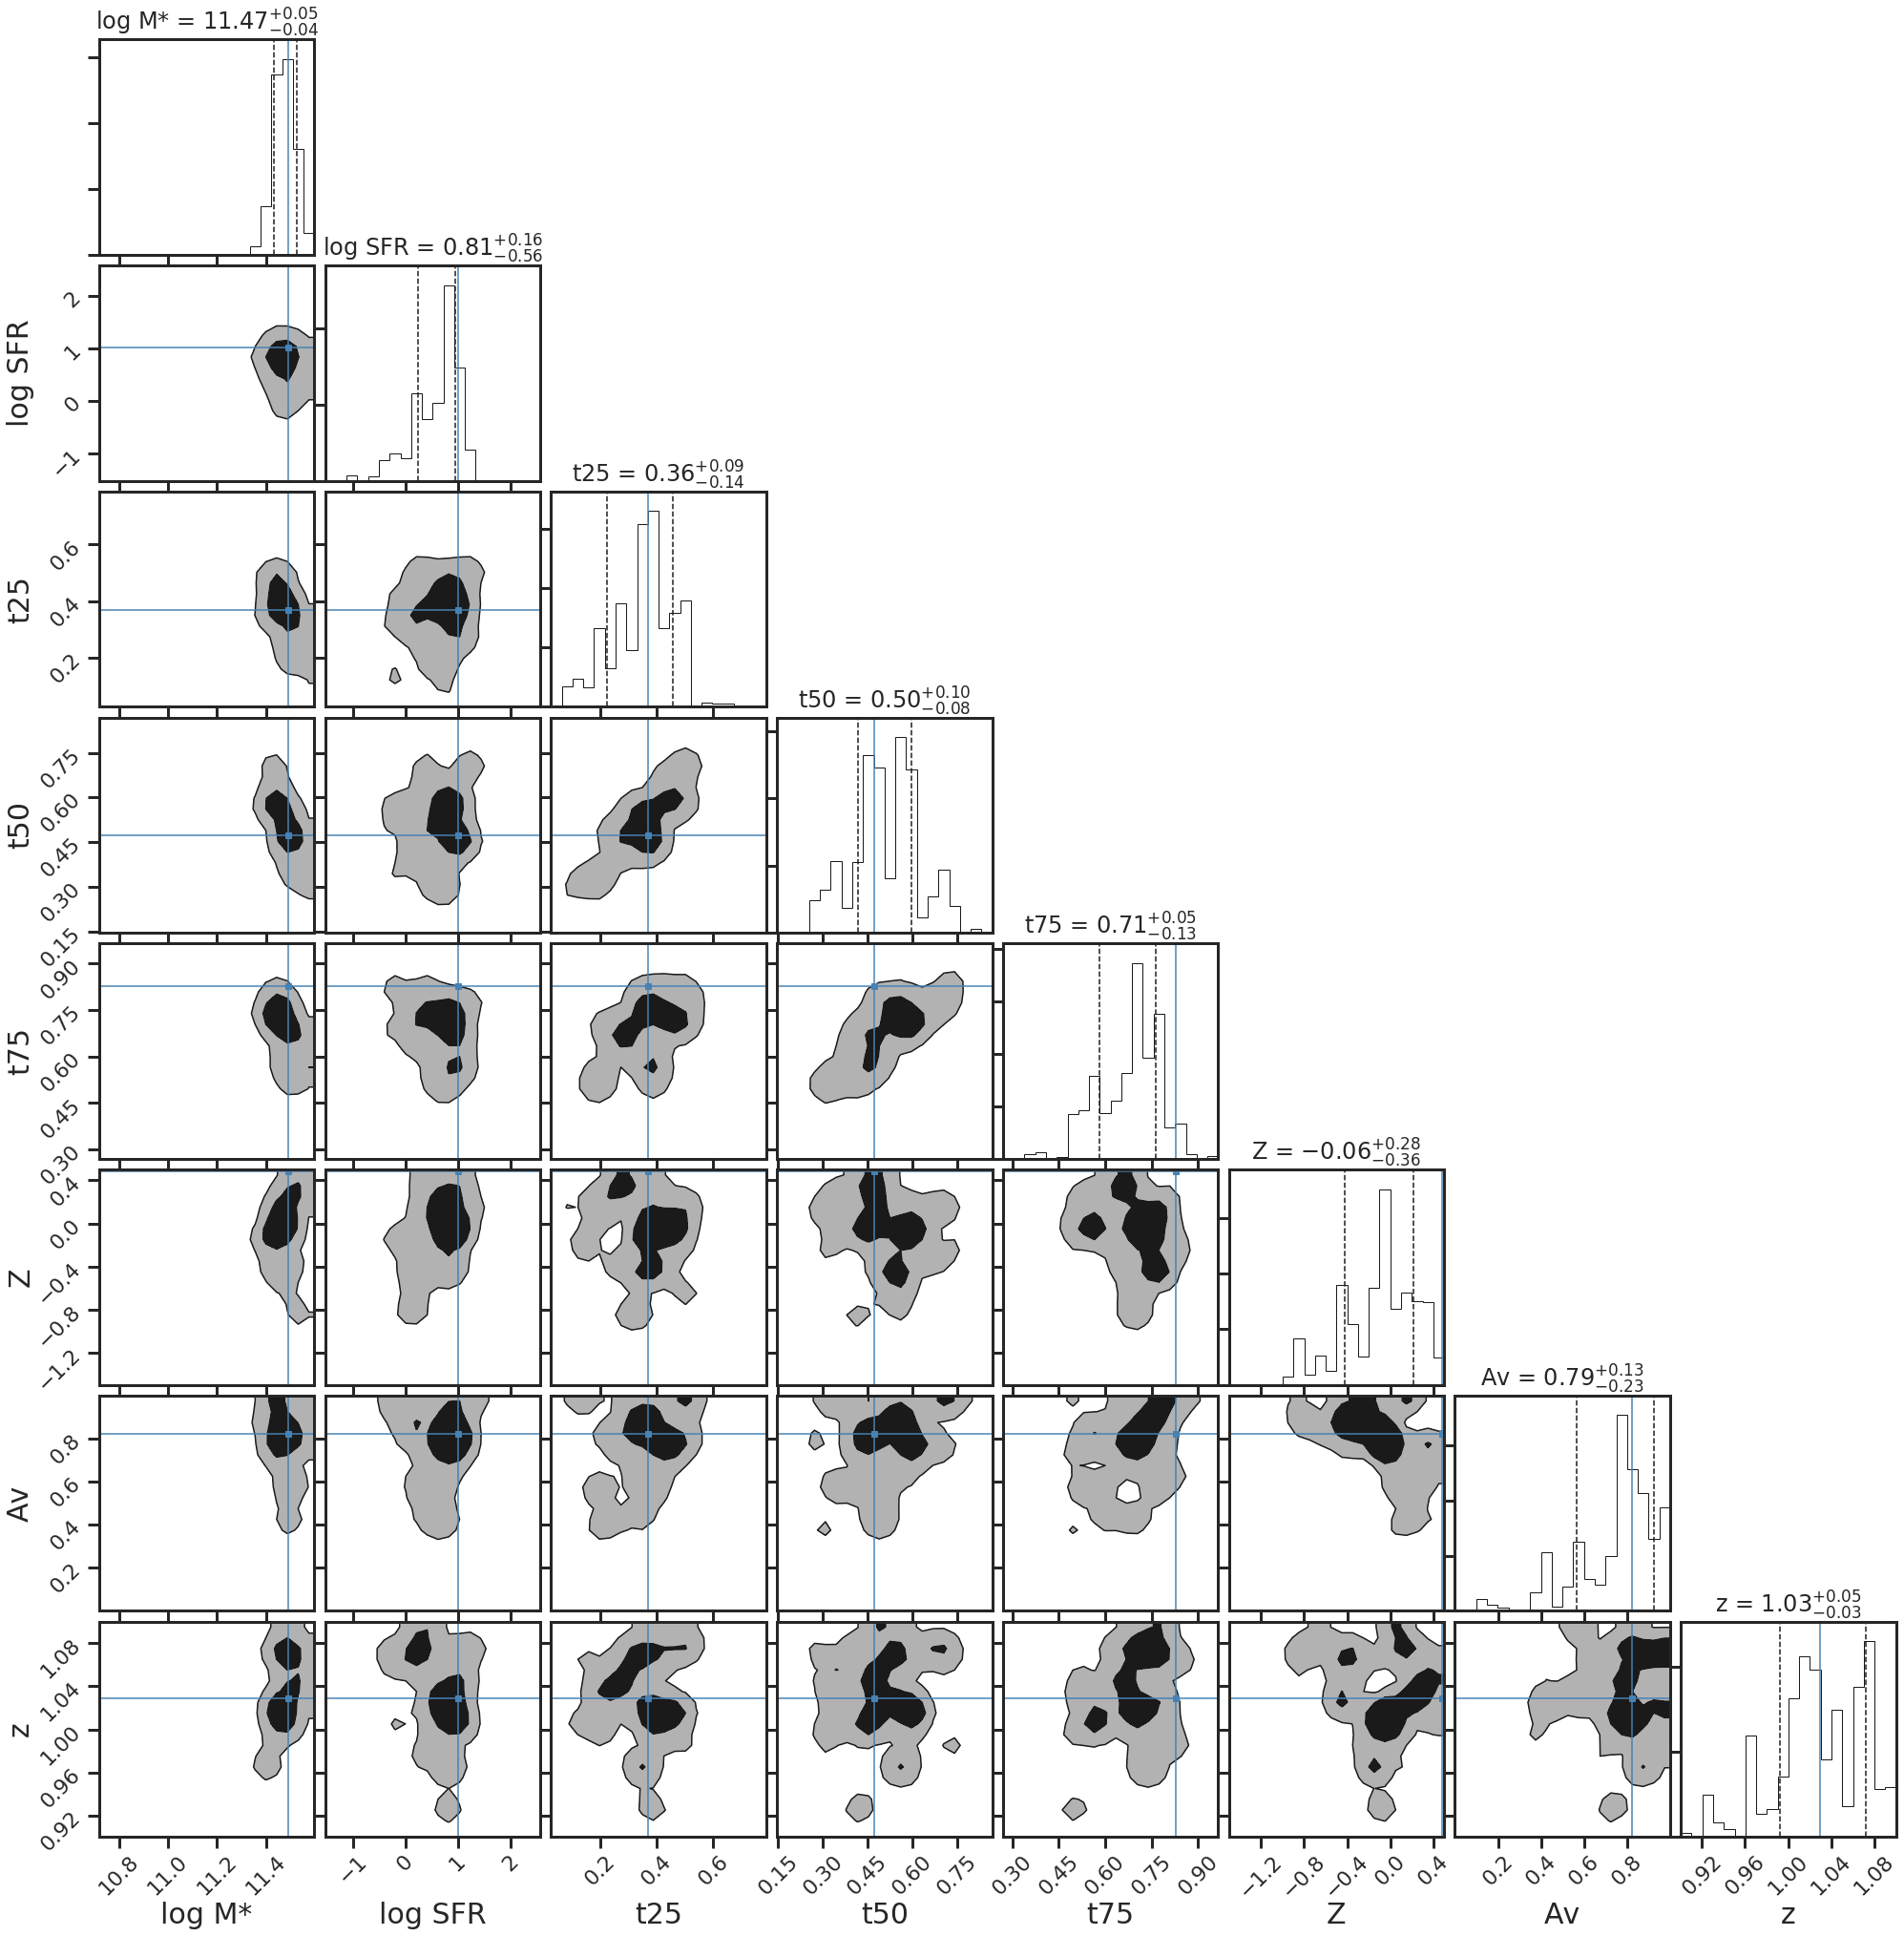

In [143]:
chi2_array = db.fit_sed_pregrid(obs_sed, obs_err,
pg_theta, return_val = 'chi2', norm_method=norm_method)

# plot parameter posteriors: 
db.plot_posteriors(chi2_array, obs_sed, pg_theta, truths = sed_truths)

### 6. Visualize the SFH posterior:

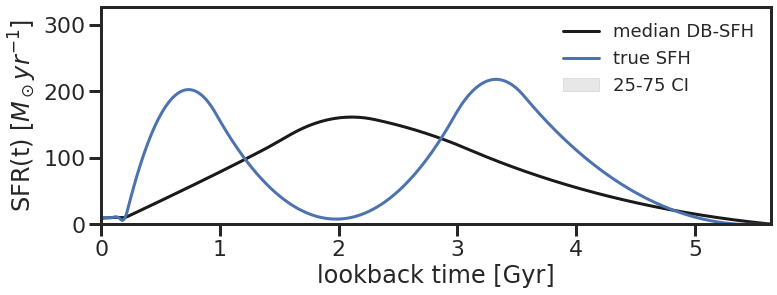

In [142]:
# plot posterior SFH 
db.plot_SFH_posterior(chi2_array, obs_sed, pg_theta, truths = sfh_truths, sfh_threshold = 0.95)